# Gorilla Assessment
## Task 1

Load and merge datasets using pandas. 

Since the point of this assignment is to give an idea of how I approach coding, I have left some of the checks/exploratory lines of code in, but commented them out as to not fill the document with intermediate results tables.

In [1]:
import pandas as pd

meter_list = pd.read_excel('gorilla_test_data.xlsx', sheet_name='meter_list')
# meter_list

In [2]:
f_cast = pd.read_excel('gorilla_test_data.xlsx', sheet_name='forecast_table')
# f_cast

In [3]:
rates = pd.read_excel('gorilla_test_data.xlsx', sheet_name='rate_table')
# rates.head()

In [4]:
# join dataframes on relevant keys
merged_df = pd.merge(f_cast, meter_list, on='meter_id', how='left', validate='m:1')
merged_df = pd.merge(merged_df, rates, on='exit_zone', how='left', validate='m:m', suffixes=('', '_r'))

# print(f_cast.shape[0] * rates.shape[0]/len(rates['exit_zone'].unique()), merged_df.shape)
# merged_df.head()

In [5]:
import numpy as np

# filter on aq range
filtered_df = merged_df.loc[merged_df['aq_kwh'] >= merged_df['aq_min_kwh']]
filtered_df = filtered_df.loc[np.logical_not(filtered_df['aq_kwh'] >= filtered_df['aq_max_kwh'])]

# obtain most recent price date
filtered_df = filtered_df.loc[filtered_df['date'] >= filtered_df['date_r']]
filtered_df = filtered_df.groupby(['meter_id', 'date']).max('date_r')

# print(f_cast.shape, filtered_df.shape)
# filtered_df

The first 3 steps could have been performed at once using 'np.logical_and' statements. Thereby reducing the number of loops through the dataframe, and perhaps reducing the number of times the dataframe is saved and moved in the memory. However, I consider the potential *very* tiny speed gain less important than the reduction in legibility. Given the emphasis on efficiency, I still wanted to mention it.

In [6]:
filtered_df['cost_in_pounds'] = 0.01 * filtered_df['kwh'] * filtered_df['rate_p_per_kwh']

meter_usage = filtered_df[['kwh', 'cost_in_pounds']].groupby(level=0).sum().round(2).reset_index()

meter_usage = meter_usage.rename(columns={'meter_id': 'Meter ID', 'kwh': 'Total Estimated Consumption (kWh)', 
                                          'cost_in_pounds': 'Total Cost (£)'})
meter_usage

,Meter ID,Total Estimated Consumption (kWh),Total Cost (£)
0,14676236,28978.0,100.15
1,34509937,78324.0,275.49
2,50264822,265667.0,731.24
3,88357331,484399.0,1433.16


## Task 2

Write a function to generate a list of meters. I am unsure if by 'list' they meant a python list, or that word was used since it is the name given in the excel sheet. Returning a pandas dataframe seems more logical given the rest of the assignment. However, a list was asked and I can display the fact that I know how to generate pandas dataframes in the next task.

In [7]:
exit_zones = rates['exit_zone'].unique()

def generate_meters(n):
    meter_id = np.unique(np.random.randint(low=10**7, high=10**8, size=n))
    while len(meter_id) < n:
        meter_id = np.unique(np.append(meter_id, np.random.randint(low=10**7, high=10**8, size=n-len(meter_id))))
        
    aq_kwh = np.random.randint(low=10**3, high=10**6, size=n)
    exit_zone = np.random.choice(exit_zones, size=n, replace=True)
    keys = ['meter_id', 'aq_kwh', 'exit_zone']
    
    return [dict(zip(keys, values)) for values in zip(meter_id, aq_kwh, exit_zone)]

# generate_meters(4)

## Task 3

In [8]:
def generate_forecast(meters, start_date, duration):
    n_meters = len(meters)
    df = pd.DataFrame({'meter_id': np.repeat([meter['meter_id'] for meter in meters], duration),
                      'date': np.tile(pd.date_range(start=start_date, periods=duration), n_meters), 
                      'kwh': np.random.rand(duration*n_meters) * 100})
    return df

# generate_forecast(generate_meters(3), '2020-05-03', 5)

## Task 4

In [9]:
def calc_transport_cost(meters, forecasts):
    meters_df = pd.DataFrame(meters)
    df = pd.merge(forecasts, meters_df, on='meter_id', how='left')
    df = pd.merge(df, rates, on='exit_zone', how='left', suffixes=('', '_r'))
    
    df = df.loc[df['aq_kwh'] >= df['aq_min_kwh']]
    df = df.loc[np.logical_not(df['aq_kwh'] >= df['aq_max_kwh'])]

    df = df.loc[df['date'] >= df['date_r']]
    df = df.groupby(['meter_id', 'date']).max('date_r')
    
    df['cost_in_pounds'] = 0.01 * df['kwh'] * df['rate_p_per_kwh']

    costs = df[['kwh', 'cost_in_pounds']].groupby(level=0).sum().round(2).reset_index()
    return costs

# meter_1 = generate_meters(3)
# fc_1 = generate_forecast(meter_1, '2020-05-03', 5)
# calc_transport_cost(meter_1, fc_1)

Given that the generated list and dataframe are ordered, I do not expect this random generation to have a meaningful effect. Just to be sure it has been included.

In [13]:
import timeit

n_meters_options = [5, 10, 20, 50]
durations = np.arange(10, 91, 20)
n_generate = 5
n_repeats = 5
number = 5
start_date = '2020-05-03'

times = []

for _ in range(n_generate):
    for n_meters in n_meters_options:
        for duration in durations:
            rand_meters = generate_meters(n_meters)
            rand_fc = generate_forecast(rand_meters, start_date, duration)
            func = lambda : calc_transport_cost(rand_meters, rand_fc)
            
            t = timeit.Timer(func)
            r = t.repeat(n_repeats, number) 
            
            times.append({'n_meters': n_meters, 'duration': duration, 'time': min(r)})

Now that the benchmark times have been generated, we can visualize them.

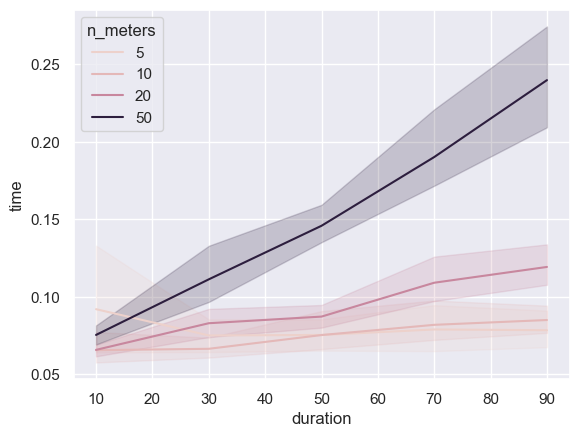

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt 

times_df = pd.DataFrame(times)
sns.set_theme()

sns.lineplot(times_df, x='duration', y='time', hue='n_meters')
plt.show()

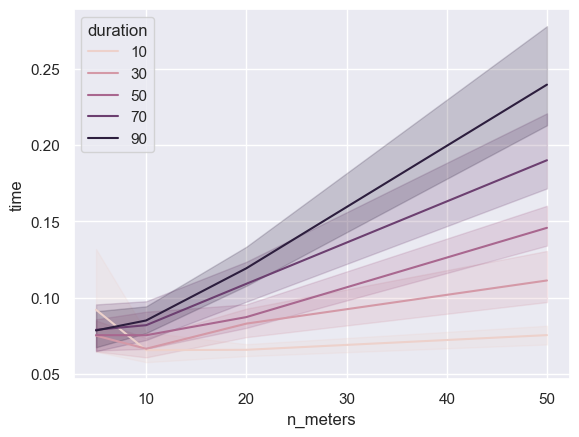

In [15]:
sns.lineplot(times_df, x='n_meters', y='time', hue='duration')
plt.show()

## Task 5

On the plots the time seems to increase more or less linearly when increasing either the number of meters or the duration over which the transport costs are calculated. This is not entirely accurate as, for instance, the merging of the dataframes has time complexity *O(n log(n))*. However, visually this is very similar to a linear function.

In optimization the first step is profiling the function, as there is little point in optimizing a part of the function that accounts for less than 1% of the required time. As pretty much all functions used are standard pandas routines, there will be plenty of discussion online as to how to optimize this. My first step would probably be to check stackoverflow. 

Another approach would be to use the properties of the dataset. For instance, the fact that they are sorted could lead to meaningful speed gains as it is far faster to merge sorted lists, than unsorted. Additionally, pricing changes only on the first of April and the first of October, and the annual quantity ranges for pricing are the same across time and exit zones. It is therefore possible to use a single look-up, rather than 

I did not do use these properties since they were not given in the assignment, so I did not feel comfortable making these assumptions. Additionally, using this information might lead to speed-ups, but the code would be less legible, higher maintenance, and more prone to errors if these assumptions are violated.